#Intro to Classification with KNN
Of the several different major classes of machine learning problems, the ones we'll investigate most extensively in this course are [Classification Problems](https://en.wikipedia.org/wiki/Statistical_classification).  In a **classification problem** the **target variable** is **categorical** and known (**supervised**), and thus the task amounts to **classifying** an observation (set of features) into the proper **category** or **class**.  Hence the learning objective is to determine a function that performs this task (mapping feature vectors to categories) with suitable accuracy.

In these exercises we'll go through 2 different datasets and perform a specific type of classification algorithm, **KNN (K-Nearest Neighbors)**, to build classification models both manually and using built-in classifiers from `sklearn`.

##Learning Goals
The packages and concepts we'll hope to get comfortable with in this activity are the following:
- [***Classification Problems***](https://en.wikipedia.org/wiki/Statistical_classification): you should understand what the classification task is and how to carry out a classification pipeline start to finish
- [***KNN with sklearn***](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html): built-in K-Nearest Neighbors Classifier class in sklearn
- [***Feature Standardization***](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html): sklearn and pandas functionality for scaling/standardizing/normalizing numeric feature data
- ***Image Features***: So far we've worked with rows of data tables, now we'll just be given images as input and learn some ways to extract structured feature data from these images
- [***KNN - How it works***](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm): You should be able to manually carry out a KNN classifier and be familiar with concepts such as different distance metrics and weighting functions
- [***Curse of Dimensionality***](https://en.wikipedia.org/wiki/Curse_of_dimensionality): issues that can arise with high-dimensional feature spaces (many features)

##Datasets
We'll take a look at 2 different datasets:
1. [Fisher Iris Dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set)  
2. [MNIST Database of Handwritten Digits](http://yann.lecun.com/exdb/mnist/)  

##Setup
Try running the following imports and check that they all import successfully.  If they do not, the commands for the installs are given below.  If necessary, at a command line window run the ones that are failing for you and then retry the imports.

In [ ]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
from seaborn import plt
from sklearn.datasets import load_iris
%matplotlib inline

###Installations (if necessary)
<pre><code>conda install pandas</code></pre>
<pre><code>conda install numpy</code></pre>
<pre><code>conda install seaborn</code></pre>
<pre><code>conda install scikit-learn</code></pre>

##Fisher Iris Dataset
For our first few exercises we'll work with the [Fisher Iris Dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) to demonstrate how **KNN Classification** might be done in `sklearn`.  The Iris Dataset contains 4 different numerical features (petal and sepal length and width (cm)) for 3 different species of flowers and the goal is to classify each observation into the proper of the 3 possible species. 

The Iris Dataset is an old and extremely common dataset in demonstrating machine learning, so much so that it's actually included in `sklearn`.  Let's load it in and explore:

In [ ]:
# Load in the Iris Dataset
iris = load_iris()
# What is the type of this object?
type(iris)

Let's check out some of the properties in a `sklearn.datasets.base.Bunch` object:

In [ ]:
# Retrieve the names of the features
feature_names = iris.feature_names
# Print the names of the features
print 'Feature Names: ' + str(feature_names)
# Retrieve the feature data
features = iris.data
# Print the type of this object
print "Type of 'features': " + str(type(features))
# Print the feature data (a numpy array)
print features

In [ ]:
# Retrieve the target variable data
target = iris.target
# Print the type of this object
print "Type of 'target': " + str(type(target))
# Print the target data (a numpy array)
print target

You should notice that the `iris` object contains both the feature data and target data stored as `numpy` arrays, and the feature names stored as a `List` of strings.  Let's combine these items to create a `pandas` Dataframe for our dataset:

In [ ]:
# Create a pandas dataframe from the feature data and feature names
df = pd.DataFrame(features, columns=feature_names)
# Add the target variable to the dataframe
df['Target'] = iris.target
# Use head to take a look
df.head(10)

###Exploring the Iris Data
If everything looks good in your dataframe, let's start exploring the data.

First let's take a look at the datatypes:

In [ ]:
# Check datatypes with info
df.info()

This makes sense, the 4 measurements are floats and the class/target variable is an indicator int representing the flower class.  Let's check out the unique target values:

In [ ]:
# Get the unique values of 'Target'
df['Target'].unique()

Good, we have 3 unique values of the 'Target' variable, one representing each possible class (species of flower).

Now let's use `seaborn` to generate some plots to explore the data further.  For each possible pair of attributes we want to generate a color-coded scatterplot of the observations with different colors for each class.

**Q: How many plots does this mean we should have and why?**

In [ ]:
# Set up the figure and axes
#we'll plot 2x3 figures (why?)
fig, axes = plt.subplots(nrows=2, ncols=3)

# Define the different colors to use for the 3 classes
colors = ['r','g','b']

# For each desired plot, create a scatterplot with the appropriate pair of attributes and the proper axis
for i in range(3): 
    tmp = df[df.Target == i]
    tmp.plot(x=0,y=1, kind='scatter', c=colors[i], ax=axes[0,0])

for i in range(3): 
    tmp = df[df.Target == i]
    tmp.plot(x=0,y=2, kind='scatter', c=colors[i], ax=axes[0,1])

for i in range(3): 
    tmp = df[df.Target == i]
    tmp.plot(x=0,y=3, kind='scatter', c=colors[i], ax=axes[0,2])
    
for i in range(3): 
    tmp = df[df.Target == i]
    tmp.plot(x=1,y=2, kind='scatter', c=colors[i], ax=axes[1,0])

for i in range(3): 
    tmp = df[df.Target == i]
    tmp.plot(x=1,y=3, kind='scatter', c=colors[i], ax=axes[1,1])

for i in range(3): 
    tmp = df[df.Target == i]
    tmp.plot(x=2,y=3, kind='scatter', c=colors[i], ax=axes[1,2])

####What do you notice from these plots?

###KNN with sklearn
Now that you should have a decent feel for the Iris data, let's use `sklearn` and **KNN** to try and classify our various flowers.  To do this we'll make use of the `KNeighborsClassifier`, ***and of course we won't forget to cross-validate!***

First, let's generate a 70/30 train/test split:

In [ ]:
#imports
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets, feature_selection
from sklearn.cross_validation import train_test_split, cross_val_score

# Create the training (and test) set using scikit-learn's train_test_split function
# Retrieve the feature data matrix
X = df.iloc[:, 0:3]
# Retrieve the target vector
y = df['Target']
# Perform a 70/30 train/test split for cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

# Note that we also could have just done the following
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=12)

# Try this sequence again with the following random seed.
# observe how it changes the scores of K quite dramatically
# X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=8)

Before we try a model, there's one more consideration.  **KNN** takes (at least) 1 parameter, the value of ***k***.  

**Q: How do we know what value of *k* to use?**

**A: **That's easy enough!  We'll just try out a whole range of ***k*** values with **cross-validation** (here a **train/test split**) and choose the model that  yields the best results!

In [ ]:
# Define a range of possible k values for KNN
n_neighbors = range(1, 51, 2)
print n_neighbors

Now that we have our k-values to try, let's find a good `KNeighborsClassifier`:

In [ ]:
# Loop through each neighbors value from 1 to 51 and record the model score in scores
scores = []
for k in n_neighbors:
    # Create a KNN Classifier with k=k
    clf = neighbors.KNeighborsClassifier(k)
    # Fit the KNN Classifier to the training set
    clf.fit(X_train, y_train)
    # Test the model against the test set and save the score
    scores.append(clf.score(X_test, y_test))

Let's plot the scores that we got against k to see what value of k might be best:

In [ ]:
# Plot model scores vs. k
plt.plot(n_neighbors, scores, linewidth=3.0)

####What appears to be the optimal value of k for this dataset?



####Why does the classification rate go down with more neighbors?



####If we have N points in our dataset, what would happen if we use N neighbors to classify each point?




### Application of k-fold Cross-Validation
The work above shows that at 11 neighbors, we can get an ideal result that doesn't overfit the data. To verify this, we'll use automated cross validation in `sklearn`.  Specifically, let's try **5-fold cross-validation** with our **k=11** model:

In [ ]:
# Import cross_val
from sklearn.cross_validation import cross_val_score

# Create the model with k=11
clf = neighbors.KNeighborsClassifier(11, weights='uniform')
# Fit the model to the full dataset
clf.fit(iris.data, iris.target)
# Have sklearn perform 5-fold cross-validation and print out the scores
scores = cross_val_score(clf, iris.data, iris.target, cv=5)
print 'Scores: ' + str(scores)
print 'Score Avg: ' + str(scores.mean())

The very high scores on this cross-validation show that this is a good model that is likely to generalize well and not overfit.  This is yet another way to do cross-validation with sklearn.

###Visualization of the Decision Boundary between Classes

Let's try to get a color-coded look at the so-called ***decision boundaries*** for our classifier.  These are the locations (boundaries) in the feature space where the predicted class changes when crossed.  To do this, we'll focus only on the last 2 features of the dataset (if you remember the scatter plots from earlier, these 2 features seemed to do the best job **separating** out the different classes properly).

First let's build a **KNN** model with **k=11** using only the last 2 features:

In [ ]:
# Create our classifier with k=11
clf = neighbors.KNeighborsClassifier(11, weights='uniform')
# Fit to the data (last 2 features and the target)
clf.fit(iris.data[:, 2:4], iris.target)

Now we'll do some manipulations to plot these decision boundaries.  Just take a look at how this works for now, you can read further into the documentation of some of these functions in the links below.

In [ ]:
h = 0.01  # step size in the mesh
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

In [ ]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, y_min = df.min()[['petal length (cm)', 'petal width (cm)']]
x_max, y_max = df.max()[['petal length (cm)', 'petal width (cm)']]

* [np.meshgrid](http://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) (build grid)
* [ravel](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html) (flatten)
* [np.c_](http://docs.scipy.org/doc/numpy-1.6.0/reference/generated/numpy.c_.html#numpy.c_)
    * `np.c_[np.array([1,2,3]), np.array([4,5,6])]` will get `[[1, 4],[2, 5],[3, 6]]`

In [ ]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

In [ ]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)

In [ ]:
plt.figure(figsize=(18,6))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

In [ ]:
# Plot also the training points
plt.figure(figsize=(18,6))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(df['petal length (cm)'], df['petal width (cm)'], c=iris.target, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = {}, weights = '{}')".format(clf.n_neighbors, clf.weights))

### Scaling
Oftentimes the features for a given dataset with have different ***scales***.  For varying types of machine learning algorithms, this can cause issues--for instance variables certain variables could tend to dominate leading to potentially unstable models.

We can rectify such issues by first scaling our features to all be of comparable scale.  The 2 most common ways to do this are:
- **Standardization**: transforming each feature value to the number of standard deviations the value is away from the mean of that feature
- **Normalization**: Dividing every feature value by the max (or min) value for that feature (amounts to scaling between 0 and 1)

You may see these terms used interchangeable, so all that's important is that you understand what each type is doing and that both are usually acceptable and improve your models.

`sklearn` has built-in functions for scaling your variables for you, but you could also perform the same manipulations yourself using `pandas`.  Here's an example:

In [ ]:
df.describe()

First let's do it with `sklearn`, using the default "standardization":

In [ ]:
from sklearn.preprocessing import scale

In [ ]:
df_norm = pd.DataFrame(scale(iris.data), columns=iris.feature_names)
df_norm.head()

Let's summarize the results, notice that the standard deviation is now 1 for every field (a consequence of standardization):

In [ ]:
df_norm.describe()

Now let's do the same thing with `pandas` manipulations:

In [ ]:
# Select the data fields
df_norm = df.iloc[:, 0:4]
# Perform the standardization operation
df_norm = (df_norm - df_norm.mean())/df_norm.std()
# Summarize the results and notice we've done the same thing
df_norm.describe()

##Exercises

In these exercises we'll try to use **KNN** for a slightly different type of classification task, that of classifying handwritten digits.  KNN is surely not the most adept algorithm to use for this task (neural networks have generally become the standard), but KNN is simple and we can do surprisingly better than random with this simple algorithm.

The full dataset that we'll be using is the **MNIST Handwritten Digit** set and can be found [here](http://yann.lecun.com/exdb/mnist/).

For these exercises, we'll first manually implement a KNN algorithm so you can better understand KNN.  After that, we'll see how easy it is to do the same work with `sklearn`.

###Loading in the Data
To this point we've used data where the features were already defined for us, but for the image dataset here we're simply given a bunch of labeled images.  How do we extract numerical features from images?

To do this we'll use the pixel values, and thus every image observation will be represented as a vector of pixel values, so there will be `num_pixel` features.

The code here handles the task of generating this feature data for you, take a look at it for future reference and understanding.

In [ ]:
import subprocess

def download(url):
    """Download a GZIP archive, return the data as a byte string."""
    # Do the download by shelling out to curl.
    cmd = 'curl "%s" | gzip -d' % url
    return subprocess.check_output(cmd, shell=True)

def get_files():
    """Download MNIST files from the internet."""
    url_format = "http://yann.lecun.com/exdb/mnist/%s-%s-idx%d-ubyte.gz"
    files = [("train", "images", 3), ("train", "labels", 1),
             ("t10k", "images", 3), ("t10k", "labels", 1)]
    
    urls = [url_format % values for values in files]
    data = [download(url) for url in urls]
    return data

data = get_files()

Now we have the raw data, the following code will parse it into the data format we want:

In [ ]:
import struct
from numpy import *

def parse_labels(data):
    """Parse labels from the binary file."""
    
    # We're going to use the Python 'struct' package. 
    # This is an incredibly nice package which allows us to specify the format
    # our data is in, and then automatically parses the data from the string.
    # Let's start by getting the magic number and the length: the first character
    # represents the endianness of the data (in our case, '>' for big endian), while
    # the next characters are the format string ('2i' for two integers).
    magic, n = struct.unpack_from('>2i', data)
    assert magic == 2049, "Wrong magic number: %d" % magic
    
    # Next, let's extract the labels.
    labels = struct.unpack_from('>%dB' % n, data, offset=8)
    return labels
    
def parse_images(data):
    """Parse images from the binary file."""
    
    # Parse metadata.
    magic, n, rows, cols = struct.unpack_from('>4i', data)
    assert magic == 2051, "Wrong magic number: %d" % magic
    
    # Get all the pixel intensity values.
    num_pixels = n * rows * cols
    pixels = struct.unpack_from('>%dB' % num_pixels, data, offset=16)
    
    # Convert this data to a NumPy array for ease of use.
    pixels = asarray(pixels, dtype=ubyte)
    
    # Reshape into actual images instead of a 1-D array of pixels.
    images = pixels.reshape((n, cols, rows))
    return images

train_images = parse_images(data[0])
train_labels = parse_labels(data[1])
test_images = parse_images(data[2])
test_labels = parse_labels(data[3])

For understanding, let's check out the data we've pulled down:

In [ ]:
# Type?
print type(train_images)
print type(train_labels)
# Dimensions?
print train_images.shape
print len(train_labels)
print test_images.shape
print len(test_labels)

Let's take a look at some of the images:

In [ ]:
from matplotlib.pyplot import *

# Get the figure and axes.
fig, axes = subplots(5, 5)
axes = axes.reshape(25)
fig.suptitle("Random Sampling of MNIST")

# Plot random images.
indices = random.randint(len(train_images), size=25)
for axis, index in zip(axes, indices):
    image = train_images[index, :, :]
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    axis.imshow(image, cmap = cm.Greys_r)

###Building a KNN Classifier
We've now stored the image data into `numpy` arrays (which is exactly what we want for our Machine Learning purposes) and we can proceed with building our classifier.

####Defining a Distance Function
The first requirement for a KNN algorithm is to have a ***distance function/metric***.  This is any function we want to specify that will yield a distance value between any 2 points in our feature space.  

For this first implementation, let's use [**Euclidean Distance**](https://en.wikipedia.org/wiki/Euclidean_distance). As an exercise, implement a function that calculates the Euclidean Distance between 2 arrays below: 
- The function should be called `euclidean_distance`
- The parameters should be `img1` and `img2`, for which we'll be expecting `numpy` arrays
- The output should return the **squared euclidean distance** (aka don't worry about taking the square root)

In [ ]:
# Create the euclidean distance function
def euclidean_distance(img1, img2):
    # Since we're using NumPy arrays, all our operations are automatically vectorized.
    # A breakdown of this expression:
    #     img1 - img2 is the pixel-wise difference between the images
    #     (img1 - img2) ** 2 is the same thing, with each value squared
    #     sum((img1 - img2) ** 2) is the sum of the elements in the matrix.
    return sum((img1 - img2) ** 2)

####Creating our own NearestNeighborsClassifier class
Here we're going to implement a skeleton of the class that will do our classification.
- Create a class called `NearestNeighborsClassifier` that inherits from `object`
- The class should be initialized by parameters `dataset` and `k`
- The class should have a function `predict` that takes a parameter `point` and returns the predicted class value
- The class should have a function `distance` that takes 2 parameters `p1` and `p2` and simply calls your `euclidean_distance` function from above on them
- The class should have a function `majority_vote` that takes a list of class votes and returns the majority class

In [114]:
from collections import defaultdict
class NearestNeighborClassifier(object):
    """A generic k-nearest neighbor predictor."""
    
    def __init__(self, dataset, k):
        """Create a new nearest neighbor classifier.

        dataset - a list of data points. Each data point is an (x, y) pair,
                  where x is the input and y is the label.
        k - the number of neighbors to search for."""
        # Note how we don't have to do any initialization!
        # Once we have a dataset, we can immediately get predictions on new values.
        self.dataset = dataset
        self.k = k
        
    def predict(self, point):
        # We have to copy the data set list, because once we've located the best
        # candidate from it, we don't want to see that candidate again, so we'll delete it.
        candidates = self.dataset[:]
    
        # Get a list of the distances to all other points
        distances = [self.distance(x[0], point) for x in candidates]
        # Sort the list
        distances_sorted = sorted(distances)
        # For the lowest k distances, add that candidate to the nearest neighbors
        neighbors = []
        for i in range(k):
            index = distances.index(distances_sorted[i])
            neighbors.append(candidates[index])

        # Predict by averaging the closets k elements.
        prediction = self.majority_vote([value[1] for value in neighbors])
        return prediction
    
    def distance(self, p1, p2):
        return euclidean_distance(p1, p2)
    
    def majority_vote(self, values):
        # For convenience, we're going to use a defaultdict.
        # This is just a dictionary where values are initialized to zero
        # if they don't exist.
        counter = defaultdict(int)
        for value in values:
            # If this weren't a defaultdict, this would error on new vote values.
            counter[value] += 1
    
        # Find out who was the majority.
        majority_count = max(counter.values())
        for key, value in counter.items():
            if value == majority_count:
                return key      

Now that we've defined our classifier, use the following few cells to:
1. Prepare our training and test data in a form our model will like
2. Use our model to predict against the test set for varying values of k
3. Plot how we did

In [115]:
# Convert our data set into an easy format to use.
# This is a list of (x, y) pairs. x is an image, y is a label.
dataset = []
for i in xrange(len(train_images)):
    dataset.append((train_images[i, :, :], train_labels[i]))
    
# Create a predictor for various values of k.
ks = [1, 2, 3, 4, 5, 6]
predictors = [NearestNeighborClassifier(dataset, k) for k in ks] 

##NOTE: Before Running this cell...
Make a duplicate copy of your current notebook via File --> Make a Copy...

While the next cell is running, work on the exercises starting with **KNN with sklearn** below.

In [116]:
def predict_test_set(predictor, test_set):
    """Compute the prediction for every element of the test set."""
    predictions = [predictor.predict(test_set[i, :, :]) 
                   for i in xrange(len(test_set))]
    return predictions

# Choose a subset of the test set. Otherwise this will never finish.
test_set = test_images[0:100, :, :]
all_predictions = [predict_test_set(predictor, test_set) for predictor in predictors]

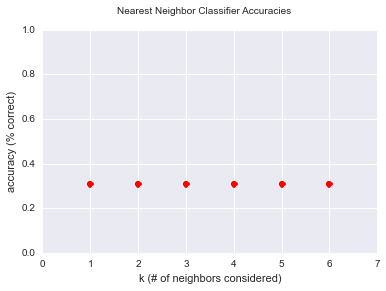

In [117]:
def evaluate_prediction(predictions, answers):
    """Compute how many were identical in the answers and predictions,
    and divide this by the number of predictions to get a percentage."""
    correct = sum(asarray(predictions) == asarray(answers))
    total = float(prod(answers.shape))
    return correct / total

labels = asarray(test_labels[0:100])
accuracies = [evaluate_prediction(pred, labels) for pred in all_predictions]

# Draw the figure.
fig = figure(1)
plt.plot(ks, accuracies, 'ro', figure=fig)

fig.suptitle("Nearest Neighbor Classifier Accuracies")
fig.axes[0].set_xlabel("k (# of neighbors considered)")
fig.axes[0].set_ylabel("accuracy (% correct)");
fig.axes[0].axis([0, max(ks) + 1, 0, 1]);

###KNN with sklearn
While your manually generated KNN process is running, let's see how simple it is to create the exact same classifier with sklearn.

####Create a train/test split
Use [`sklearn.cross_validation.train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to create a 70/30 train test split of the image data.
- Use only the testing data from before (`test_images` and `test_labels`) as your new full dataset
- Pass that data to train_test_split
- Return the output as `X_train`, `X_test`, `y_train`, `y_test`

In [118]:
#Import sklearn.cross_validation.train_test_split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(test_images, test_labels, test_size=0.3)

Take a look at the sizes of the resulting sets by calling `shape`:

In [119]:
X_train.shape

(7000, 28, 28)

Right now we have a 3D array, we need to convert everything to a 2D array for sklearn.  We can do this by calling numpy's [`reshape`]() function
- Call reshape on `X_train` and `X_test` with parameters `7000` and `28*28` for `X_train` and `3000` and `28*28` for `X_test` to properly format our data arrays
- Store these results into `X_train` and `X_test`

In [120]:
# Reshape X_train
X_train = X_train.reshape(7000, 28*28)
# Reshape X_test
X_test = X_test.reshape(3000, 28*28)
# Print out the shapes of each now
print X_train.shape
print X_test.shape

(7000, 784)
(3000, 784)


####Create and Fit a Model
- Import [`sklearn.neighbors.KNeighborsClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- Create a KNeighborsClassifier object
- Use `fit()` to fit the model to the training set
- Use `score()` to score the model on the test set

In [121]:
# Import
from sklearn.neighbors import KNeighborsClassifier
# Create Model
knn = KNeighborsClassifier()
# Fit the model
knn.fit(X_train, y_train)
# Score the model
knn.score(X_test, y_test)

0.94399999999999995

###Further Exercises
####Changing Distance Metrics
1. If you like, try a different distance metric for your manual model by updating the distance function you defined above.  Feel free to google around for possible other distance metrics.
2. With sklearn you can set the `metric` parameter in your classifier to any [sklearn.neighbors.DistanceMetric](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html) class.  The default is Euclidean, try experimenting with different DistanceMetrics.

####Adding Weights
1. In your manual model above, try updating the voting scheme so that votes are only given the weight proportional to the inverse distance.  
2. Try doing this same thing in `sklearn` by specifying the `weights` parameter in defining your model.

####Varying k
Try varying the k-value input into `sklearn` and see if you can find the optimal value.  Optionally, make a plot of the performance vs. different k-values.